In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'Conv_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 10))
fixed_data, _ = next(iter(test_loader))

In [6]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [7]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [9]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
            
        self.fce = FullyConnected([32*2*2, latent_size*2])
        self.fcd = FullyConnected([latent_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.fce(flatten)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        x = self.decode(h)
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size])
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu**2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
        else:
            self.KLD = KLD.sum()
        self._loss = F.mse_loss(output, target, size_average=size_average)
        
        return self._loss + self.gamma*self.KLD

In [10]:
models = {'VAE10': Net(10, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [11]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [12]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()
    
    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                    test_reconstruction_loss[k], 
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            ae_data = models[k](fixed_data).data.numpy()
            fixed_gen = models[k].decode(fixed_z).data.numpy()
            plot_mnist(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses VAE10: 0.9068
Train Epoch: 1 [10000/50000 (20%)]	Losses VAE10: 0.5448
Train Epoch: 1 [20000/50000 (40%)]	Losses VAE10: 0.4427
Train Epoch: 1 [30000/50000 (60%)]	Losses VAE10: 0.3860
Train Epoch: 1 [40000/50000 (80%)]	Losses VAE10: 0.3632
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE10: 0.3203


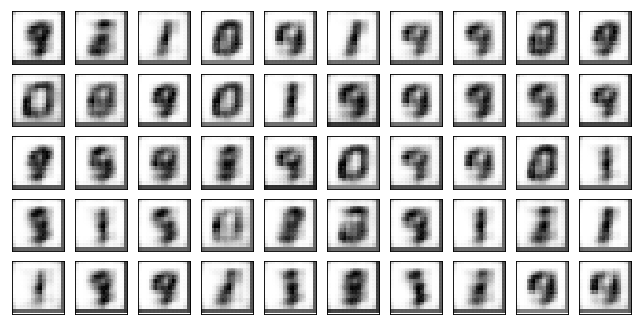

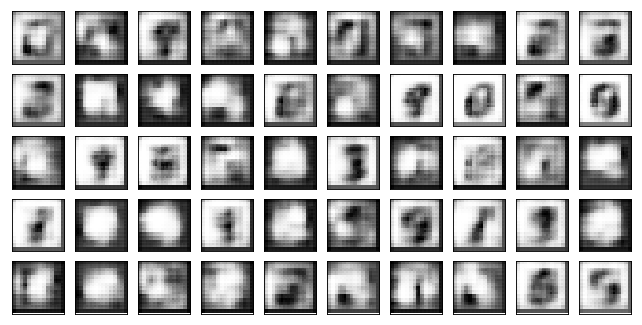

Test losses: VAE10: 0.3072/5.5388
Train Epoch: 2 [0/50000 (0%)]	Losses VAE10: 0.3203
Train Epoch: 2 [10000/50000 (20%)]	Losses VAE10: 0.2839
Train Epoch: 2 [20000/50000 (40%)]	Losses VAE10: 0.2621
Train Epoch: 2 [30000/50000 (60%)]	Losses VAE10: 0.2479
Train Epoch: 2 [40000/50000 (80%)]	Losses VAE10: 0.2281
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE10: 0.1936


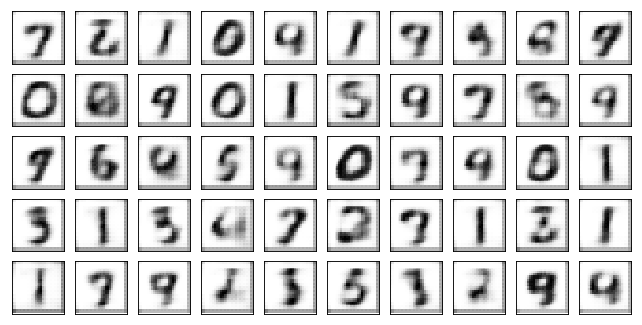

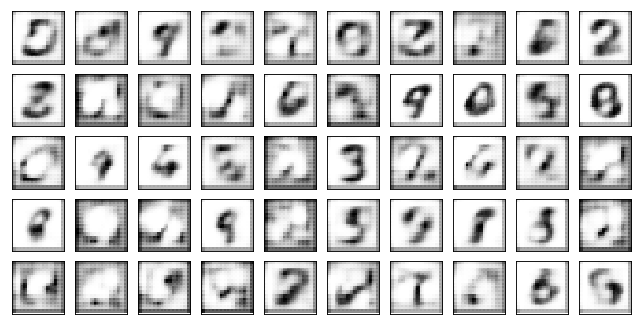

Test losses: VAE10: 0.1809/8.5964
Train Epoch: 3 [0/50000 (0%)]	Losses VAE10: 0.2031
Train Epoch: 3 [10000/50000 (20%)]	Losses VAE10: 0.1916
Train Epoch: 3 [20000/50000 (40%)]	Losses VAE10: 0.1774
Train Epoch: 3 [30000/50000 (60%)]	Losses VAE10: 0.1745
Train Epoch: 3 [40000/50000 (80%)]	Losses VAE10: 0.1625
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE10: 0.1552


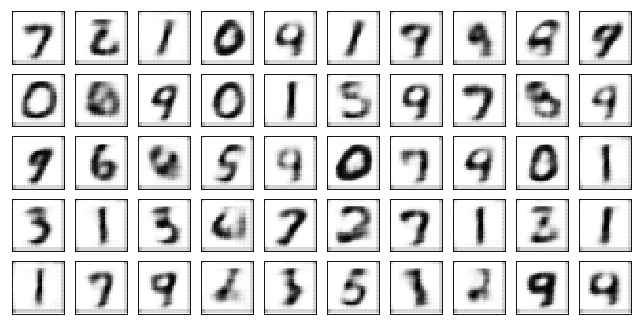

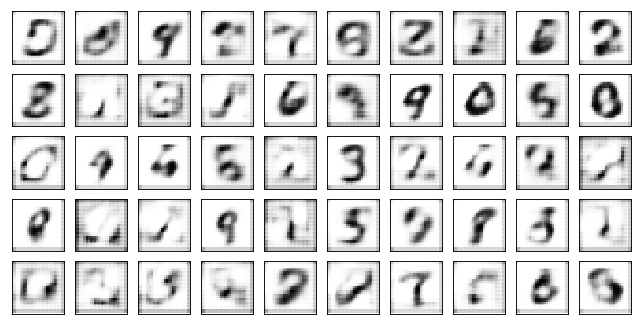

Test losses: VAE10: 0.1347/9.4838
Train Epoch: 4 [0/50000 (0%)]	Losses VAE10: 0.1657
Train Epoch: 4 [10000/50000 (20%)]	Losses VAE10: 0.1596
Train Epoch: 4 [20000/50000 (40%)]	Losses VAE10: 0.1451
Train Epoch: 4 [30000/50000 (60%)]	Losses VAE10: 0.1591
Train Epoch: 4 [40000/50000 (80%)]	Losses VAE10: 0.1410
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE10: 0.1366


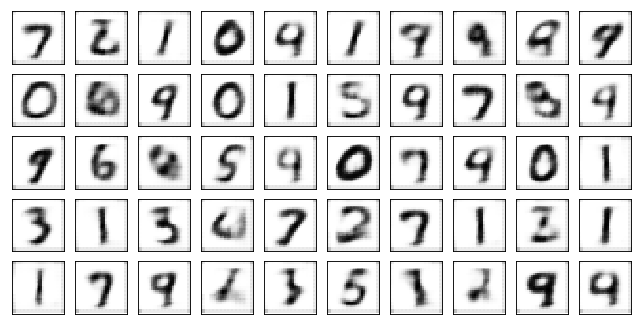

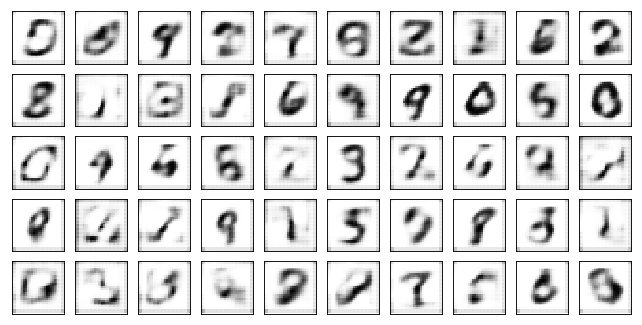

Test losses: VAE10: 0.1187/9.6011
Train Epoch: 5 [0/50000 (0%)]	Losses VAE10: 0.1340
Train Epoch: 5 [10000/50000 (20%)]	Losses VAE10: 0.1400
Train Epoch: 5 [20000/50000 (40%)]	Losses VAE10: 0.1378
Train Epoch: 5 [30000/50000 (60%)]	Losses VAE10: 0.1401
Train Epoch: 5 [40000/50000 (80%)]	Losses VAE10: 0.1279
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE10: 0.1427


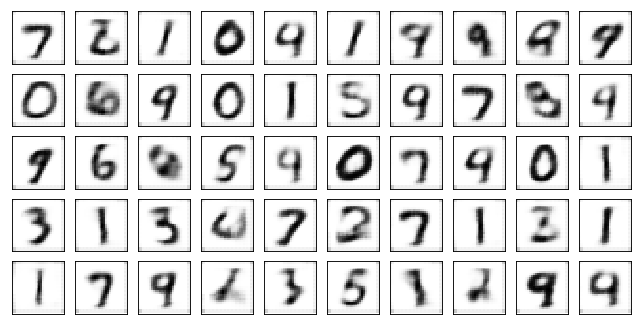

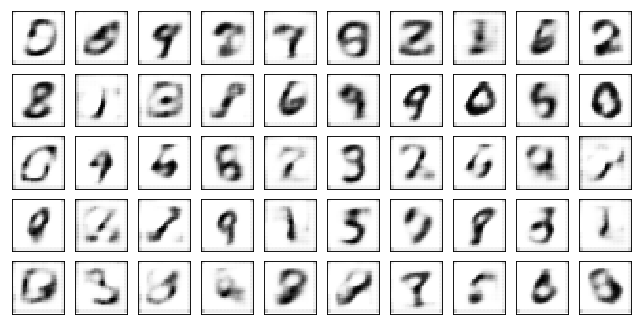

Test losses: VAE10: 0.1106/9.5958
Train Epoch: 6 [0/50000 (0%)]	Losses VAE10: 0.1302
Train Epoch: 6 [10000/50000 (20%)]	Losses VAE10: 0.1353
Train Epoch: 6 [20000/50000 (40%)]	Losses VAE10: 0.1268
Train Epoch: 6 [30000/50000 (60%)]	Losses VAE10: 0.1214
Train Epoch: 6 [40000/50000 (80%)]	Losses VAE10: 0.1219
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE10: 0.1271


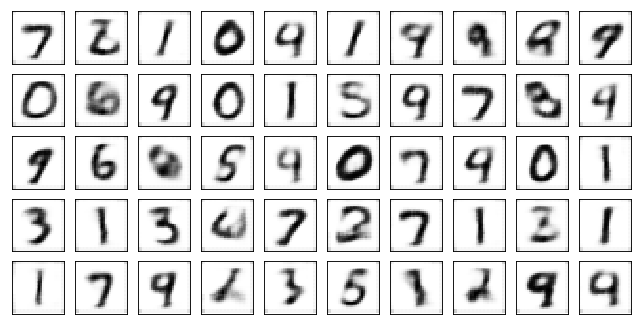

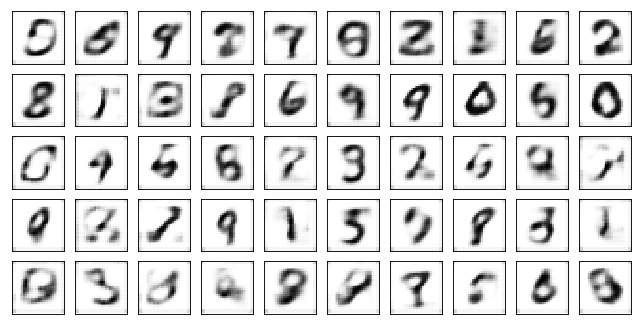

Test losses: VAE10: 0.1047/9.9970
Train Epoch: 7 [0/50000 (0%)]	Losses VAE10: 0.1160
Train Epoch: 7 [10000/50000 (20%)]	Losses VAE10: 0.1211
Train Epoch: 7 [20000/50000 (40%)]	Losses VAE10: 0.1177
Train Epoch: 7 [30000/50000 (60%)]	Losses VAE10: 0.1113
Train Epoch: 7 [40000/50000 (80%)]	Losses VAE10: 0.1322
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE10: 0.1328


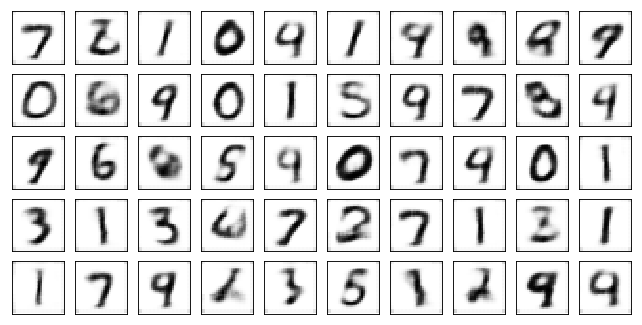

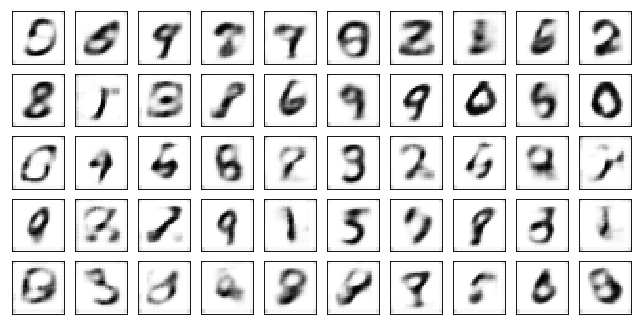

Test losses: VAE10: 0.1005/10.2472
Train Epoch: 8 [0/50000 (0%)]	Losses VAE10: 0.1230
Train Epoch: 8 [10000/50000 (20%)]	Losses VAE10: 0.1217
Train Epoch: 8 [20000/50000 (40%)]	Losses VAE10: 0.1178
Train Epoch: 8 [30000/50000 (60%)]	Losses VAE10: 0.1249
Train Epoch: 8 [40000/50000 (80%)]	Losses VAE10: 0.1182
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE10: 0.1166


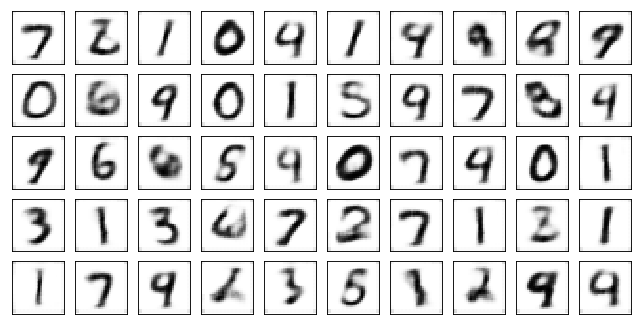

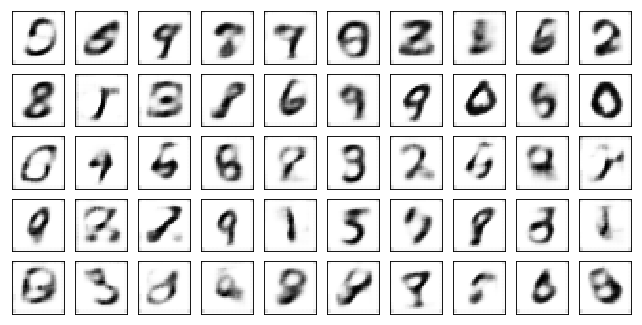

Test losses: VAE10: 0.0975/10.1476
Train Epoch: 9 [0/50000 (0%)]	Losses VAE10: 0.1171
Train Epoch: 9 [10000/50000 (20%)]	Losses VAE10: 0.1143
Train Epoch: 9 [20000/50000 (40%)]	Losses VAE10: 0.1213
Train Epoch: 9 [30000/50000 (60%)]	Losses VAE10: 0.1090
Train Epoch: 9 [40000/50000 (80%)]	Losses VAE10: 0.1020
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE10: 0.1153


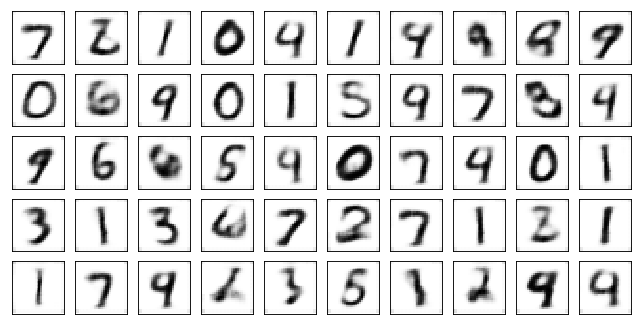

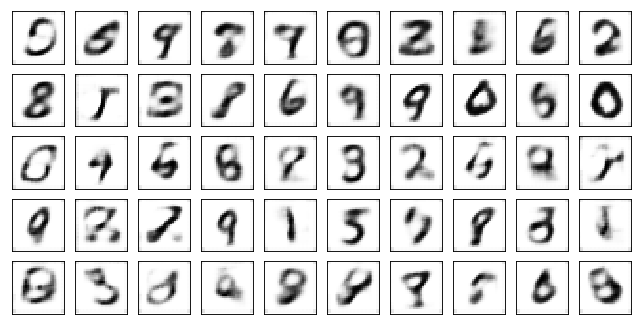

Test losses: VAE10: 0.0948/10.4723
Train Epoch: 10 [0/50000 (0%)]	Losses VAE10: 0.1222
Train Epoch: 10 [10000/50000 (20%)]	Losses VAE10: 0.1216
Train Epoch: 10 [20000/50000 (40%)]	Losses VAE10: 0.1263
Train Epoch: 10 [30000/50000 (60%)]	Losses VAE10: 0.1132
Train Epoch: 10 [40000/50000 (80%)]	Losses VAE10: 0.1141
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE10: 0.1197


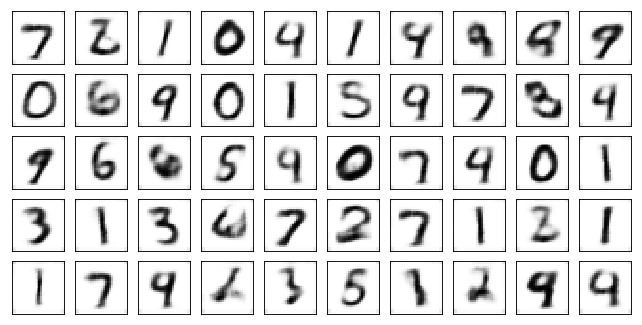

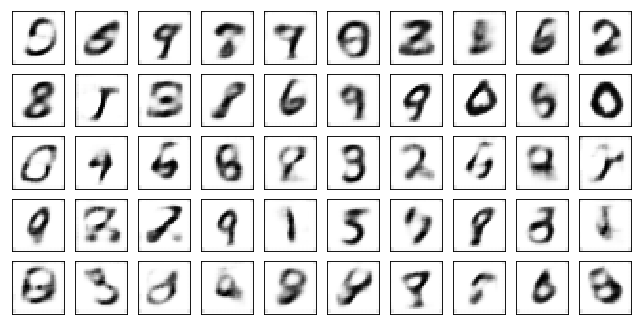

Test losses: VAE10: 0.0930/10.4407
Train Epoch: 11 [0/50000 (0%)]	Losses VAE10: 0.1215
Train Epoch: 11 [10000/50000 (20%)]	Losses VAE10: 0.1261
Train Epoch: 11 [20000/50000 (40%)]	Losses VAE10: 0.1095
Train Epoch: 11 [30000/50000 (60%)]	Losses VAE10: 0.1084
Train Epoch: 11 [40000/50000 (80%)]	Losses VAE10: 0.1098
Train Epoch: 11 [50000/50000 (100%)]	Losses VAE10: 0.1101


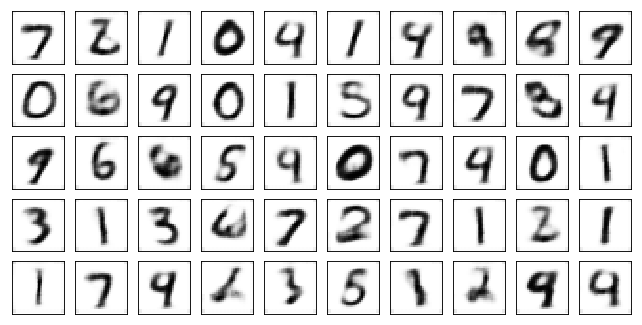

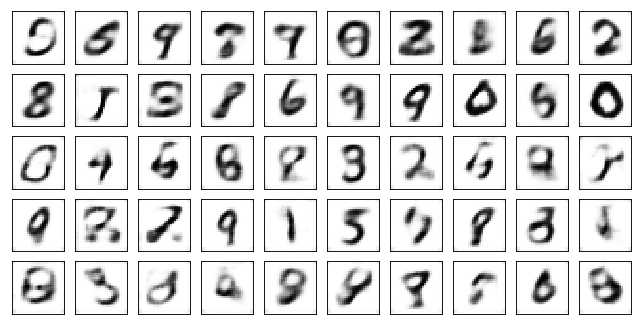

Test losses: VAE10: 0.0910/10.4084
Train Epoch: 12 [0/50000 (0%)]	Losses VAE10: 0.1194
Train Epoch: 12 [10000/50000 (20%)]	Losses VAE10: 0.1075
Train Epoch: 12 [20000/50000 (40%)]	Losses VAE10: 0.1013
Train Epoch: 12 [30000/50000 (60%)]	Losses VAE10: 0.1110
Train Epoch: 12 [40000/50000 (80%)]	Losses VAE10: 0.1161
Train Epoch: 12 [50000/50000 (100%)]	Losses VAE10: 0.1092


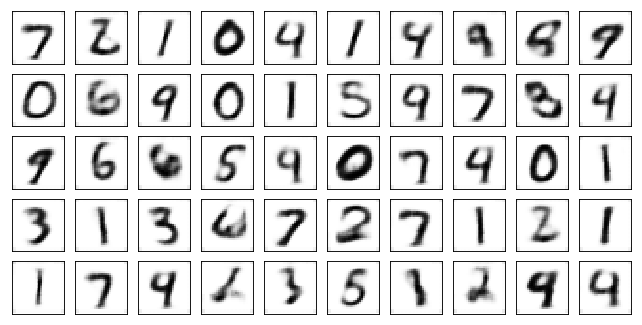

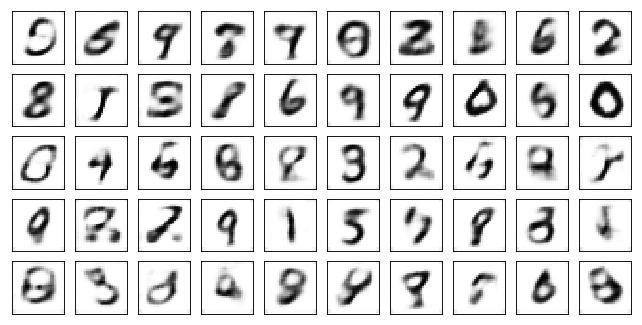

Test losses: VAE10: 0.0892/10.6658
Train Epoch: 13 [0/50000 (0%)]	Losses VAE10: 0.1120
Train Epoch: 13 [10000/50000 (20%)]	Losses VAE10: 0.1065
Train Epoch: 13 [20000/50000 (40%)]	Losses VAE10: 0.1030
Train Epoch: 13 [30000/50000 (60%)]	Losses VAE10: 0.1090
Train Epoch: 13 [40000/50000 (80%)]	Losses VAE10: 0.1165
Train Epoch: 13 [50000/50000 (100%)]	Losses VAE10: 0.1149


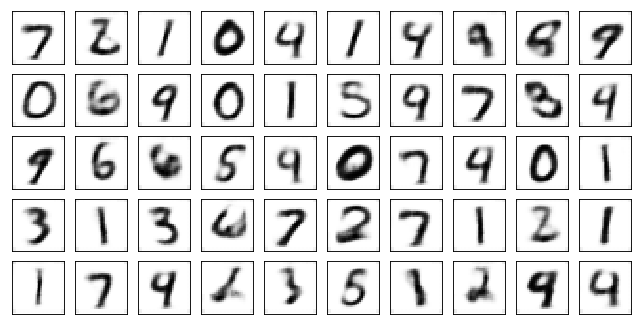

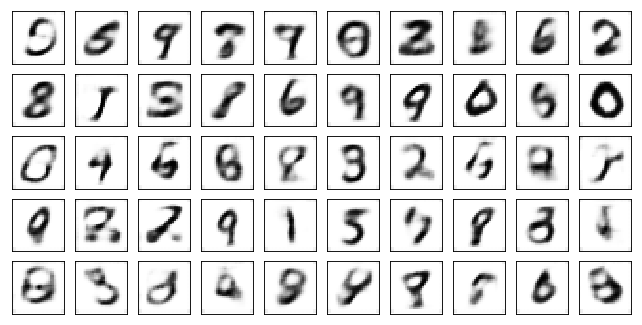

Test losses: VAE10: 0.0884/10.5927
Train Epoch: 14 [0/50000 (0%)]	Losses VAE10: 0.1147
Train Epoch: 14 [10000/50000 (20%)]	Losses VAE10: 0.1275
Train Epoch: 14 [20000/50000 (40%)]	Losses VAE10: 0.1178
Train Epoch: 14 [30000/50000 (60%)]	Losses VAE10: 0.1165
Train Epoch: 14 [40000/50000 (80%)]	Losses VAE10: 0.1030
Train Epoch: 14 [50000/50000 (100%)]	Losses VAE10: 0.1135


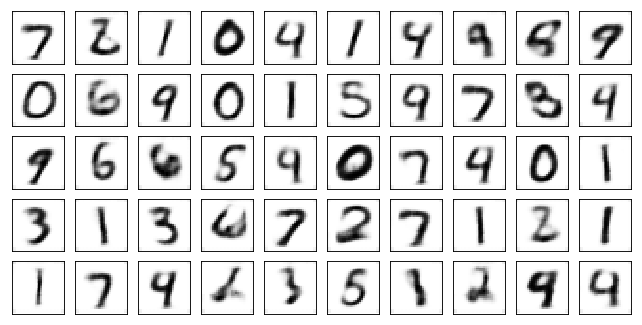

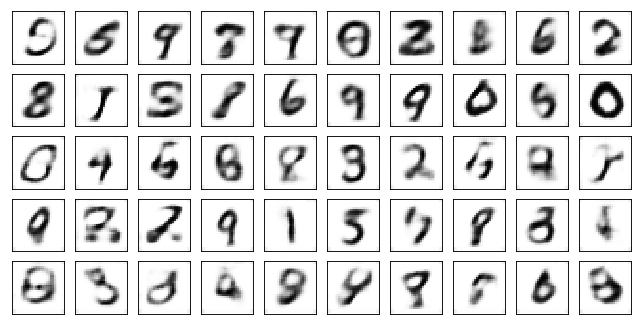

Test losses: VAE10: 0.0872/10.6139
Train Epoch: 15 [0/50000 (0%)]	Losses VAE10: 0.1209
Train Epoch: 15 [10000/50000 (20%)]	Losses VAE10: 0.0979
Train Epoch: 15 [20000/50000 (40%)]	Losses VAE10: 0.1060
Train Epoch: 15 [30000/50000 (60%)]	Losses VAE10: 0.1074
Train Epoch: 15 [40000/50000 (80%)]	Losses VAE10: 0.1101
Train Epoch: 15 [50000/50000 (100%)]	Losses VAE10: 0.1023


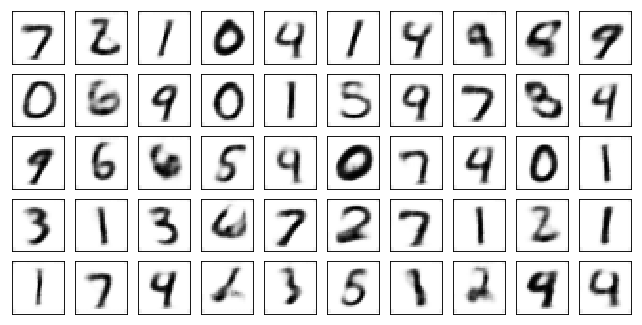

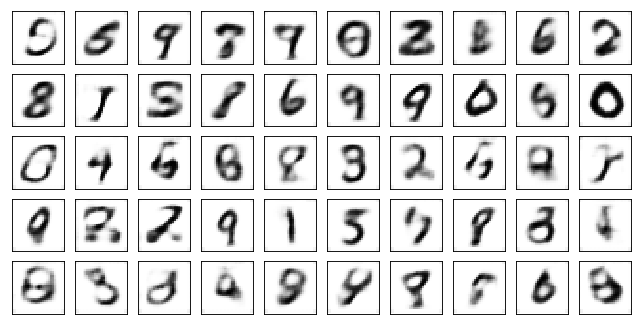

Test losses: VAE10: 0.0861/10.7704
Train Epoch: 16 [0/50000 (0%)]	Losses VAE10: 0.1052
Train Epoch: 16 [10000/50000 (20%)]	Losses VAE10: 0.1049
Train Epoch: 16 [20000/50000 (40%)]	Losses VAE10: 0.1079
Train Epoch: 16 [30000/50000 (60%)]	Losses VAE10: 0.1124
Train Epoch: 16 [40000/50000 (80%)]	Losses VAE10: 0.0993
Train Epoch: 16 [50000/50000 (100%)]	Losses VAE10: 0.1090


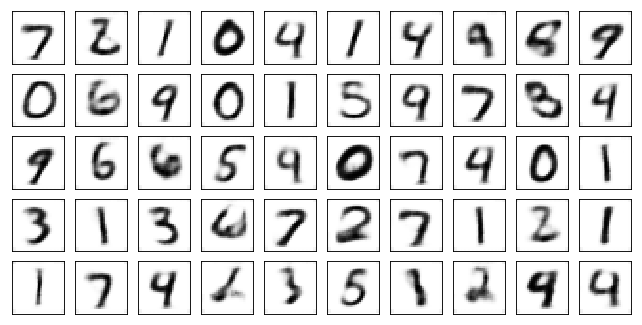

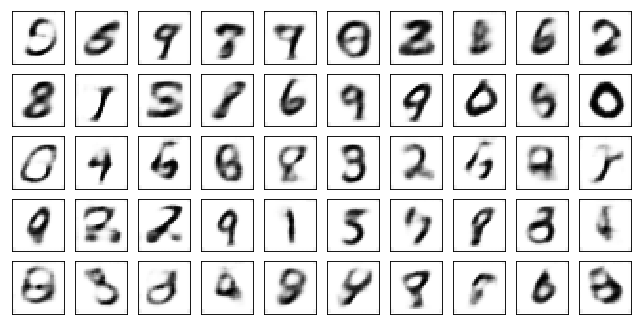

Test losses: VAE10: 0.0849/10.7720
Train Epoch: 17 [0/50000 (0%)]	Losses VAE10: 0.1161
Train Epoch: 17 [10000/50000 (20%)]	Losses VAE10: 0.1009
Train Epoch: 17 [20000/50000 (40%)]	Losses VAE10: 0.1136
Train Epoch: 17 [30000/50000 (60%)]	Losses VAE10: 0.1138
Train Epoch: 17 [40000/50000 (80%)]	Losses VAE10: 0.1124
Train Epoch: 17 [50000/50000 (100%)]	Losses VAE10: 0.1048


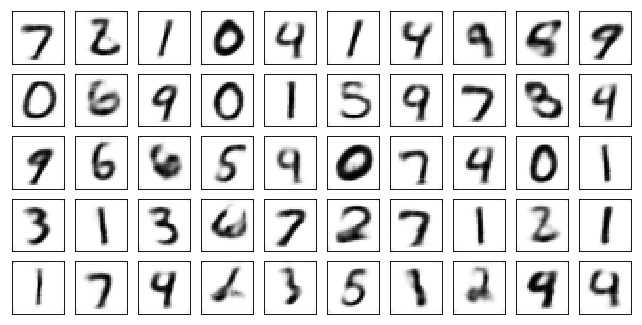

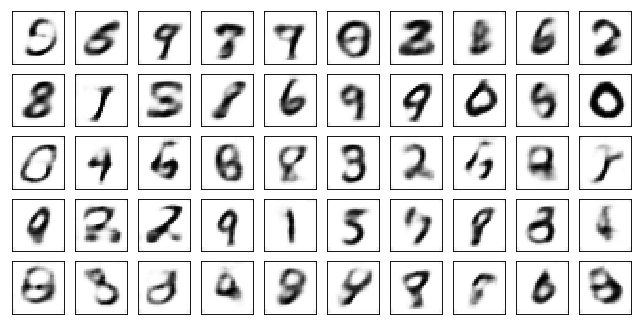

Test losses: VAE10: 0.0844/10.8179
Train Epoch: 18 [0/50000 (0%)]	Losses VAE10: 0.1084
Train Epoch: 18 [10000/50000 (20%)]	Losses VAE10: 0.1077
Train Epoch: 18 [20000/50000 (40%)]	Losses VAE10: 0.1041
Train Epoch: 18 [30000/50000 (60%)]	Losses VAE10: 0.0966
Train Epoch: 18 [40000/50000 (80%)]	Losses VAE10: 0.1182
Train Epoch: 18 [50000/50000 (100%)]	Losses VAE10: 0.1151


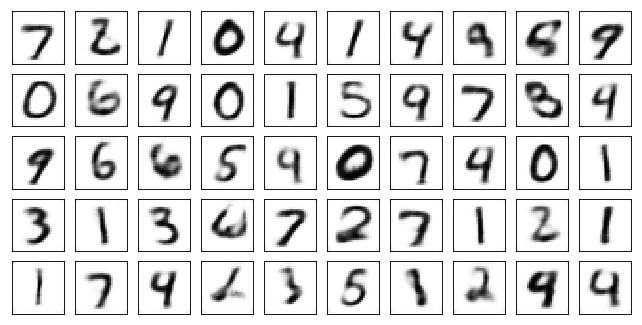

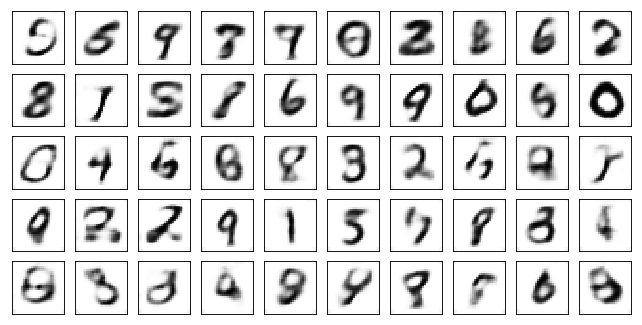

Test losses: VAE10: 0.0835/10.9885
Train Epoch: 19 [0/50000 (0%)]	Losses VAE10: 0.1121
Train Epoch: 19 [10000/50000 (20%)]	Losses VAE10: 0.1025
Train Epoch: 19 [20000/50000 (40%)]	Losses VAE10: 0.1106
Train Epoch: 19 [30000/50000 (60%)]	Losses VAE10: 0.1105
Train Epoch: 19 [40000/50000 (80%)]	Losses VAE10: 0.1055
Train Epoch: 19 [50000/50000 (100%)]	Losses VAE10: 0.1055


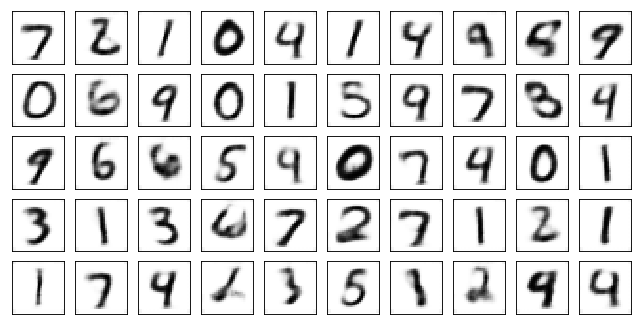

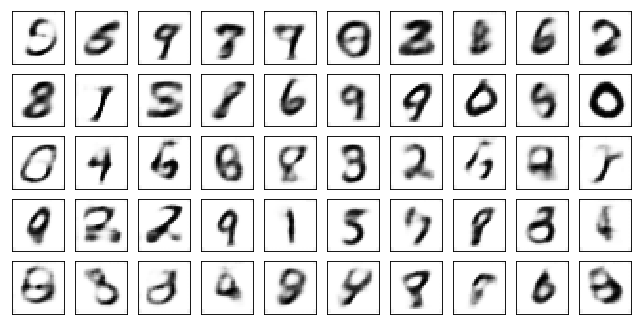

Test losses: VAE10: 0.0829/10.8955
Train Epoch: 20 [0/50000 (0%)]	Losses VAE10: 0.1021
Train Epoch: 20 [10000/50000 (20%)]	Losses VAE10: 0.0941
Train Epoch: 20 [20000/50000 (40%)]	Losses VAE10: 0.1033
Train Epoch: 20 [30000/50000 (60%)]	Losses VAE10: 0.1102
Train Epoch: 20 [40000/50000 (80%)]	Losses VAE10: 0.1039
Train Epoch: 20 [50000/50000 (100%)]	Losses VAE10: 0.1046


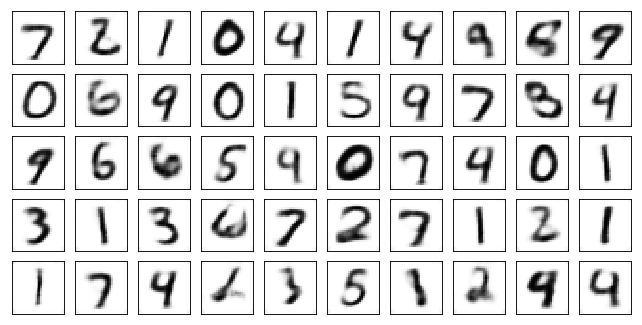

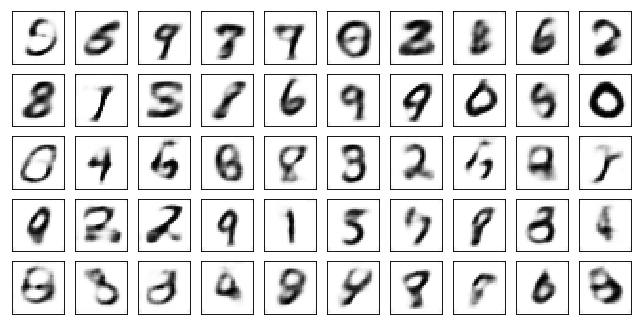

Test losses: VAE10: 0.0817/11.0230
Train Epoch: 21 [0/50000 (0%)]	Losses VAE10: 0.1109
Train Epoch: 21 [10000/50000 (20%)]	Losses VAE10: 0.1116
Train Epoch: 21 [20000/50000 (40%)]	Losses VAE10: 0.1087
Train Epoch: 21 [30000/50000 (60%)]	Losses VAE10: 0.1051
Train Epoch: 21 [40000/50000 (80%)]	Losses VAE10: 0.0986
Train Epoch: 21 [50000/50000 (100%)]	Losses VAE10: 0.1008


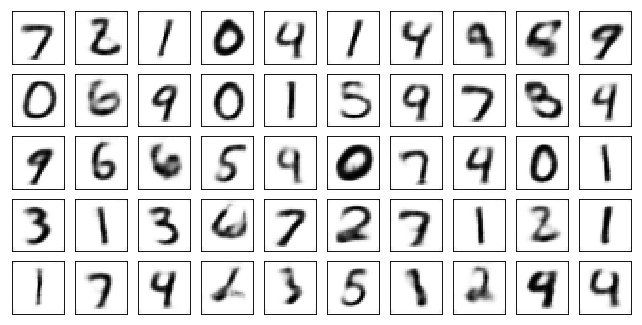

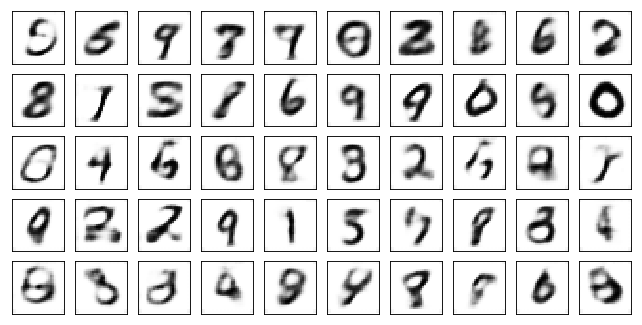

Test losses: VAE10: 0.0816/11.0960
Train Epoch: 22 [0/50000 (0%)]	Losses VAE10: 0.1166
Train Epoch: 22 [10000/50000 (20%)]	Losses VAE10: 0.1145
Train Epoch: 22 [20000/50000 (40%)]	Losses VAE10: 0.0986
Train Epoch: 22 [30000/50000 (60%)]	Losses VAE10: 0.1099
Train Epoch: 22 [40000/50000 (80%)]	Losses VAE10: 0.1046
Train Epoch: 22 [50000/50000 (100%)]	Losses VAE10: 0.0992


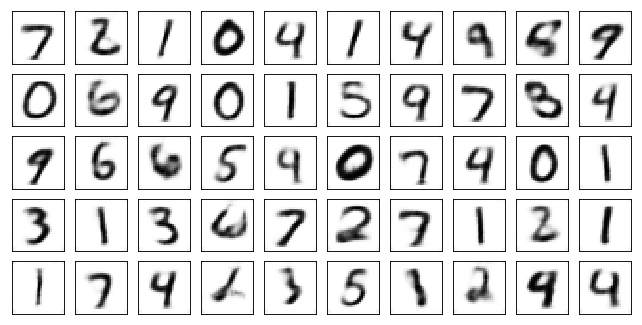

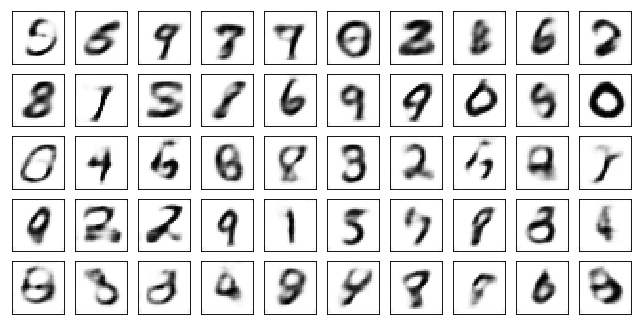

Test losses: VAE10: 0.0806/10.9386
Train Epoch: 23 [0/50000 (0%)]	Losses VAE10: 0.1028
Train Epoch: 23 [10000/50000 (20%)]	Losses VAE10: 0.1038
Train Epoch: 23 [20000/50000 (40%)]	Losses VAE10: 0.0905
Train Epoch: 23 [30000/50000 (60%)]	Losses VAE10: 0.1037
Train Epoch: 23 [40000/50000 (80%)]	Losses VAE10: 0.1001
Train Epoch: 23 [50000/50000 (100%)]	Losses VAE10: 0.1118


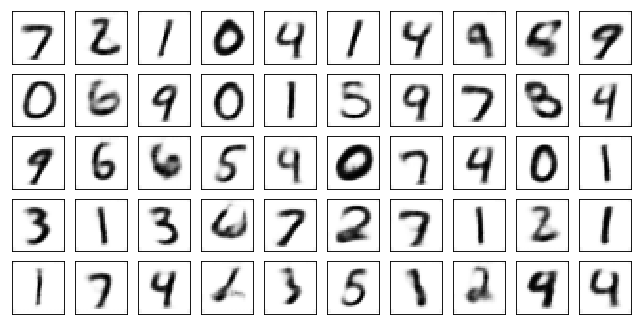

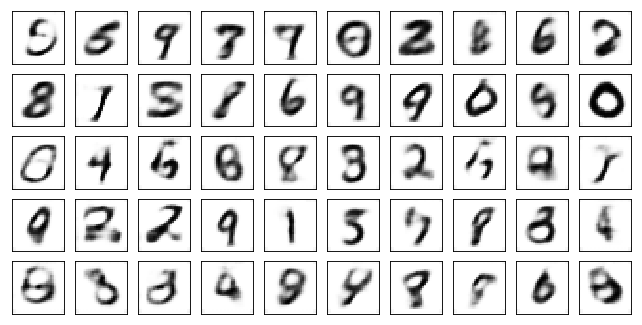

Test losses: VAE10: 0.0802/11.0125
Train Epoch: 24 [0/50000 (0%)]	Losses VAE10: 0.1004
Train Epoch: 24 [10000/50000 (20%)]	Losses VAE10: 0.1074
Train Epoch: 24 [20000/50000 (40%)]	Losses VAE10: 0.0955
Train Epoch: 24 [30000/50000 (60%)]	Losses VAE10: 0.1089
Train Epoch: 24 [40000/50000 (80%)]	Losses VAE10: 0.1083
Train Epoch: 24 [50000/50000 (100%)]	Losses VAE10: 0.1005


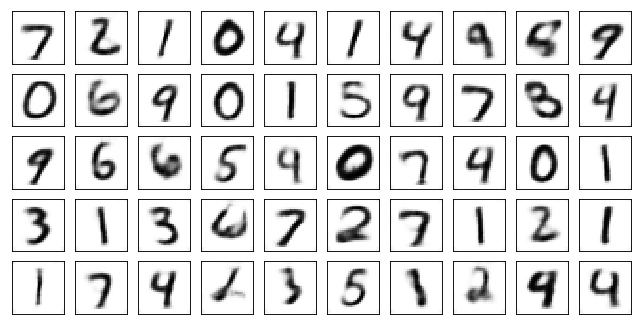

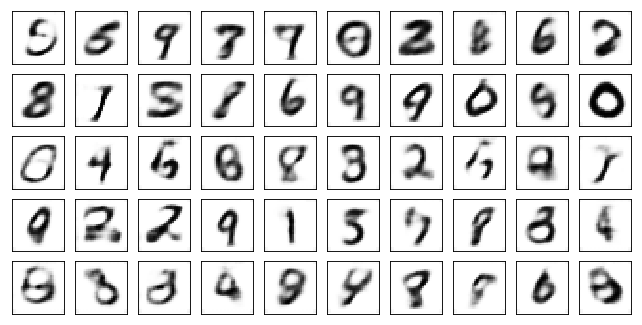

Test losses: VAE10: 0.0796/11.1765
Train Epoch: 25 [0/50000 (0%)]	Losses VAE10: 0.0971
Train Epoch: 25 [10000/50000 (20%)]	Losses VAE10: 0.1070
Train Epoch: 25 [20000/50000 (40%)]	Losses VAE10: 0.1016
Train Epoch: 25 [30000/50000 (60%)]	Losses VAE10: 0.1091
Train Epoch: 25 [40000/50000 (80%)]	Losses VAE10: 0.0993
Train Epoch: 25 [50000/50000 (100%)]	Losses VAE10: 0.0903


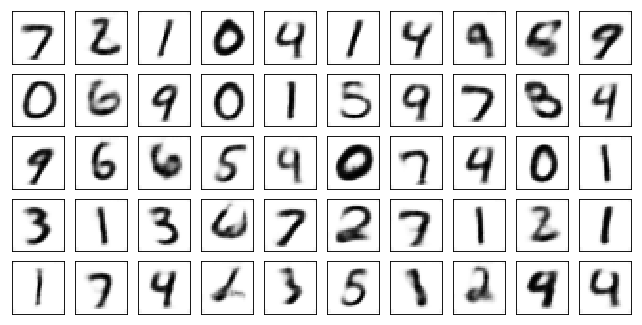

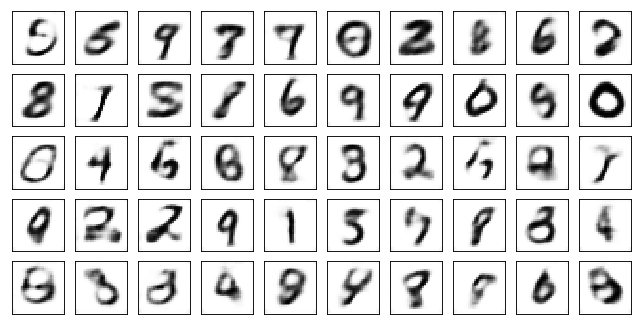

Test losses: VAE10: 0.0794/11.1128
Train Epoch: 26 [0/50000 (0%)]	Losses VAE10: 0.1039
Train Epoch: 26 [10000/50000 (20%)]	Losses VAE10: 0.1001
Train Epoch: 26 [20000/50000 (40%)]	Losses VAE10: 0.0964
Train Epoch: 26 [30000/50000 (60%)]	Losses VAE10: 0.1012
Train Epoch: 26 [40000/50000 (80%)]	Losses VAE10: 0.1055
Train Epoch: 26 [50000/50000 (100%)]	Losses VAE10: 0.1010


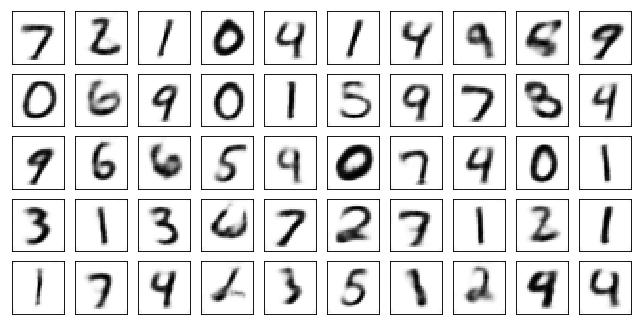

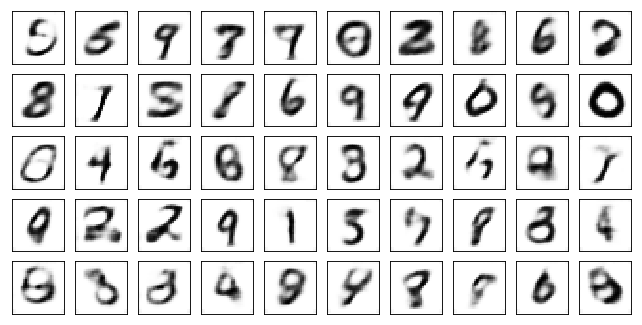

Test losses: VAE10: 0.0790/11.3048
Train Epoch: 27 [0/50000 (0%)]	Losses VAE10: 0.0945
Train Epoch: 27 [10000/50000 (20%)]	Losses VAE10: 0.0991
Train Epoch: 27 [20000/50000 (40%)]	Losses VAE10: 0.1006
Train Epoch: 27 [30000/50000 (60%)]	Losses VAE10: 0.1082
Train Epoch: 27 [40000/50000 (80%)]	Losses VAE10: 0.0997
Train Epoch: 27 [50000/50000 (100%)]	Losses VAE10: 0.0932


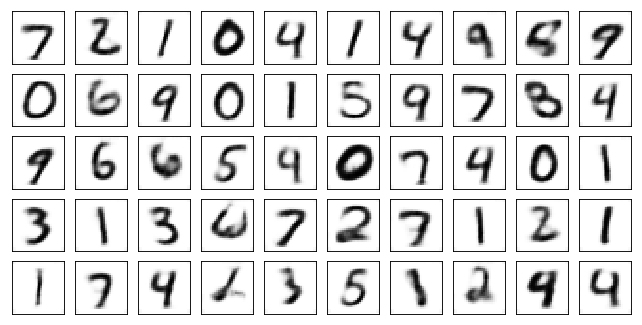

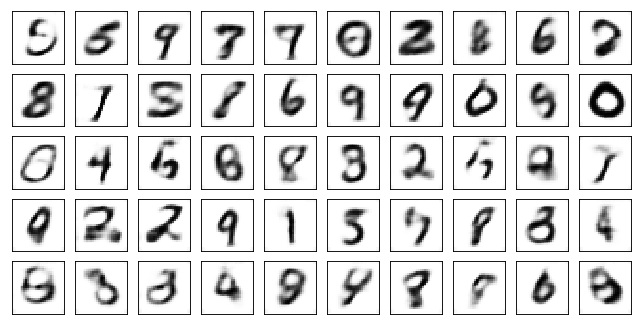

Test losses: VAE10: 0.0782/11.0086
Train Epoch: 28 [0/50000 (0%)]	Losses VAE10: 0.0968
Train Epoch: 28 [10000/50000 (20%)]	Losses VAE10: 0.1092
Train Epoch: 28 [20000/50000 (40%)]	Losses VAE10: 0.1041
Train Epoch: 28 [30000/50000 (60%)]	Losses VAE10: 0.0981
Train Epoch: 28 [40000/50000 (80%)]	Losses VAE10: 0.0907
Train Epoch: 28 [50000/50000 (100%)]	Losses VAE10: 0.1039


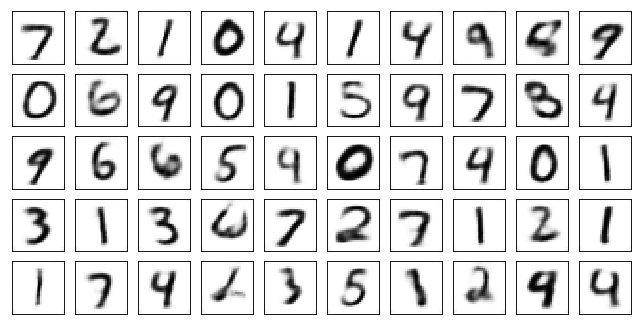

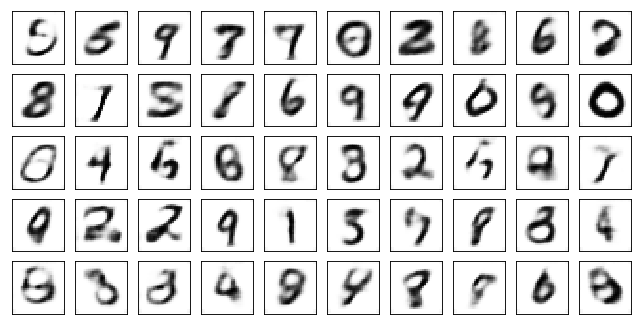

Test losses: VAE10: 0.0779/11.1443
Train Epoch: 29 [0/50000 (0%)]	Losses VAE10: 0.0907
Train Epoch: 29 [10000/50000 (20%)]	Losses VAE10: 0.0853
Train Epoch: 29 [20000/50000 (40%)]	Losses VAE10: 0.0953
Train Epoch: 29 [30000/50000 (60%)]	Losses VAE10: 0.1020
Train Epoch: 29 [40000/50000 (80%)]	Losses VAE10: 0.0933
Train Epoch: 29 [50000/50000 (100%)]	Losses VAE10: 0.1015


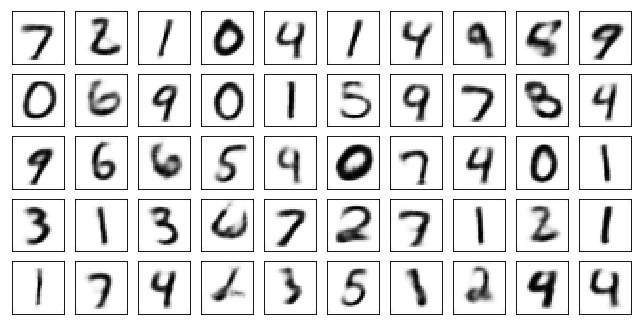

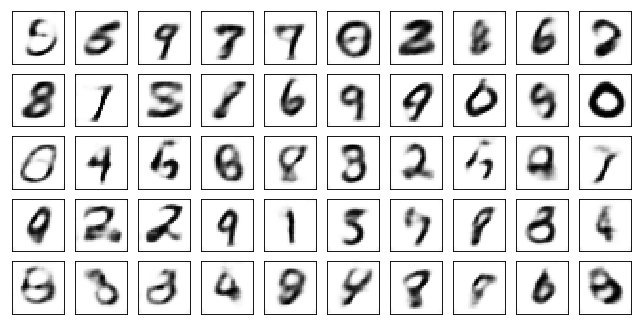

Test losses: VAE10: 0.0774/10.9938
Train Epoch: 30 [0/50000 (0%)]	Losses VAE10: 0.0981
Train Epoch: 30 [10000/50000 (20%)]	Losses VAE10: 0.1047
Train Epoch: 30 [20000/50000 (40%)]	Losses VAE10: 0.0978
Train Epoch: 30 [30000/50000 (60%)]	Losses VAE10: 0.1028
Train Epoch: 30 [40000/50000 (80%)]	Losses VAE10: 0.0891
Train Epoch: 30 [50000/50000 (100%)]	Losses VAE10: 0.0928


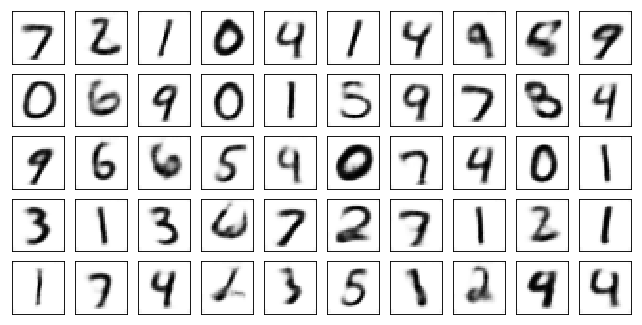

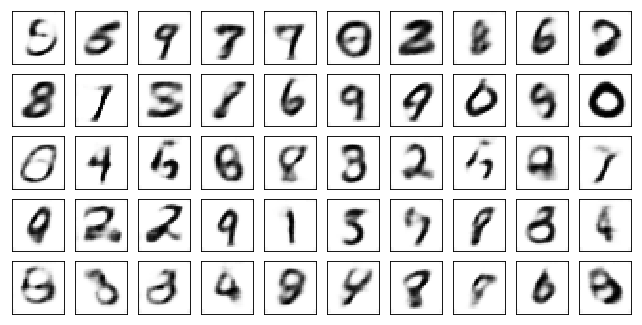

Test losses: VAE10: 0.0778/11.3712


In [13]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)